# Super resolution data preparation

Project implementing super resolution for scanned images to be used in text extraction applications such as Tesseract 4.

## Setup

Read libraries and functions

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make help libraries available
import sys
sys.path.append('D:/anlaursen/libraries')
sys.path.append('../')

# Set visible devices, so as to just use a single GPU.
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
from PIL import Image
import numpy as np

from super_resolution.address_generator import AddressGenerator
from super_resolution.super_resolution import SuperResolution
from image_augmentation.image_augmentation import Augmentor

Using TensorFlow backend.


In [3]:
PATH = '../'

## Data generation and augmentation

Test data generation

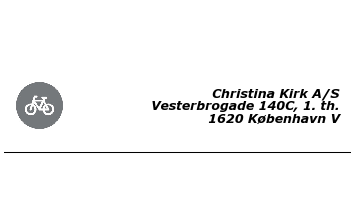

In [4]:
# Construct
addr = AddressGenerator(companies_path = PATH + '/data/company_list.pkl',
                        addresses_path = PATH + '/data/address_list.pkl',
                        logos_path = PATH + '/data/logos.pkl')

# Generate
addr.generate_header(1)

# Visualize
Image.fromarray(addr.headers_hr[0])

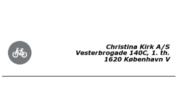

In [5]:
Image.fromarray(addr.headers_lr[0])

Test image augmentation

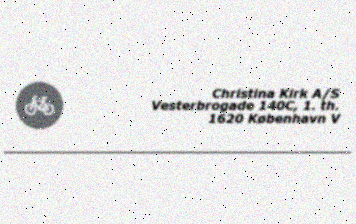

In [6]:
# Construct
augmentor = Augmentor(rotation_range = 0,
                      shear_range = 0,
                      shift_range = 0,
                      gaussian_blur_sd = 3,
                      gauss_noise_sd = 15,
                      salt_and_pepper_noise_intensity = 0.002,
                      rgb_color_shift = 30)

# Generate
augmented_images = augmentor.augment(addr.headers_hr)

# Visualize
Image.fromarray(augmented_images[0])

## Super resolution

Construct super resolution model. Start by generating data

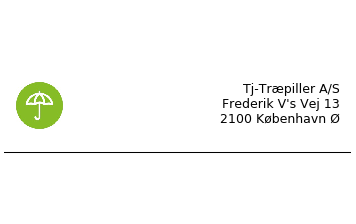

In [7]:
# Construct
addr = AddressGenerator(companies_path = PATH + '/data/company_list.pkl',
                        addresses_path = PATH + '/data/address_list.pkl',
                        logos_path = PATH + '/data/logos.pkl')

# Generate
addr.generate_header(25000)

# Visualize
Image.fromarray(addr.headers_hr[0])

Augment images

In [8]:
augmented_images = augmentor.augment(addr.headers_lr)

Inspect shapes

In [9]:
shape_hr = addr.headers_hr.shape
shape_lr = augmented_images.shape

print(shape_hr)
print(shape_lr)

(25000, 224, 356, 3)
(25000, 112, 178, 3)


Initialise model

In [10]:
super_resolution = SuperResolution(shape = shape_hr[1:])

Compile model

In [11]:
super_resolution.compile_single_gpu()

Inspect model

In [12]:
super_resolution.m_style.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 64 15616       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 64 256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 64 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

Train model

In [13]:
super_resolution.fit(augmented_images, addr.headers_hr, batch_size = 8, epochs = 2, learning_rate = 1e-4)

In [14]:
super_resolution.fit(augmented_images, addr.headers_hr, batch_size = 8, epochs = 4, learning_rate = 1e-3)

In [15]:
super_resolution.fit(augmented_images, addr.headers_hr, batch_size = 8, epochs = 4, learning_rate = 1e-4)

KeyboardInterrupt: 

In [ ]:
print (1)

In [16]:
super_resolution.get_top()

In [17]:
super_resolution.top_model.save_weights(PATH + 'results/augmentation_noise.h5')

In [18]:
super_resolution.top_model.save(PATH + 'results/augmentation_noise_model.h5')

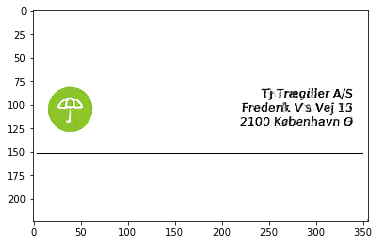

3480/|/[loss: 140.599] :  14%|| 3480/25000 [04:08<23:54, 15.00it/s]                                  

In [19]:
import matplotlib.pyplot as plt

prediction = super_resolution.top_model.predict(np.expand_dims(np.array(addr.headers_lr[0]), 0))[0]

plt.imshow(prediction.astype('uint8'))

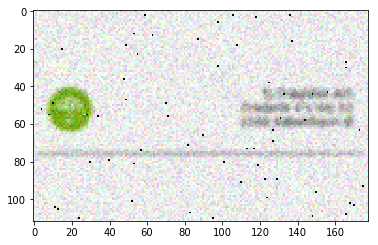

In [20]:
plt.imshow(augmented_images[0])

In [21]:
addr_new = AddressGenerator(companies_path = PATH + '/data/company_list.pkl',
                        addresses_path = PATH + '/data/address_list.pkl',
                        logos_path = PATH + '/data/logos.pkl')

# Generate
addr_new.generate_header(1)

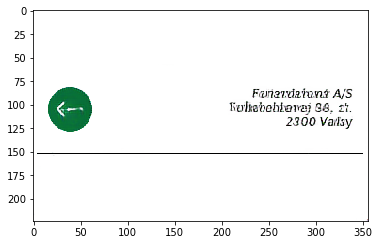

In [29]:
import matplotlib.pyplot as plt

prediction = super_resolution.top_model.predict(np.expand_dims(np.array(augmented_images[0]), 0))[0]

plt.imshow(prediction.astype('uint8'))

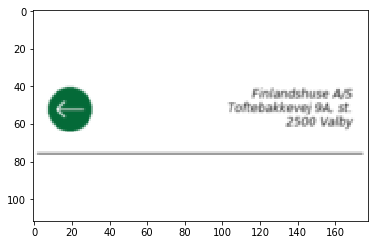

In [25]:
plt.imshow(addr_new.headers_lr[0])

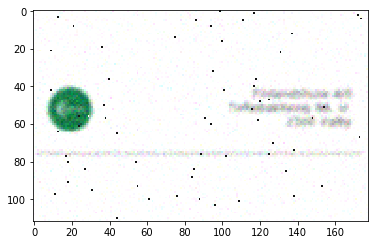

In [60]:
# Construct
augmentor = Augmentor(rotation_range = 0,
                      shear_range = 0,
                      shift_range = 0,
                      gaussian_blur_sd = 0.0005,
                      gauss_noise_sd = 15,
                      salt_and_pepper_noise_intensity = 0.002,
                      rgb_color_shift = 30)

# Generate
augmented_images = augmentor.augment(addr_new.headers_lr)

# Visualize
plt.imshow(augmented_images[0])